# Negative deembedding
> Are very negative scores helpful?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

import pandas as pd
import matplotlib.pyplot as plt

from transformer_lens import utils

from mats.loading import load_all
from mats.linearization import analyze_linearized_feature
from mats.visualization import visualize_topk

In [35]:
FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 4542, 63202, 73  # it is
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 8, 38, 73 # ')
# FEATURE_ID, SAMPLE_IDX, TOKEN_IDX = 4958, 7030, 98  # is (theology)

# visualize_topk(FEATURE_ID, 10, model, data)

In [23]:
model, data, sae = load_all(fold_ln=True, half_precision=False)

Loaded pretrained model gelu-1l into HookedTransformer
Moving model to device:  cuda
Model device: cuda:0
Tokens shape: torch.Size([215402, 128]), dtype: torch.int64, device: cuda:0
Loading run1 from HuggingFace at 25
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}
Encoder device: cuda:0


In [36]:
result = analyze_linearized_feature(
    feature_idx=FEATURE_ID,
    sample_idx=SAMPLE_IDX,
    token_idx=TOKEN_IDX,
    layer=0,
    head=0,
    model=model,
    encoder=sae,
    data=data,
    use_ln=False,
    mlp_out=False,
)

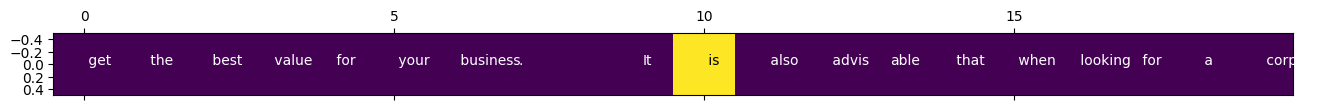

In [37]:
# model.tokenizer.decode(data[SAMPLE_IDX])

acts = result["sae activations"].detach().cpu().numpy()[None, TOKEN_IDX - 10 : TOKEN_IDX + 10, FEATURE_ID]
plt.matshow(acts)
for i in range(-10, 10):
    col = "white" if acts[0, i + 10] == 0 else "black"
    plt.text(i + 10, 0, model.tokenizer.decode(data[SAMPLE_IDX][i + TOKEN_IDX]), color=col)

In [38]:
out, cache = model.run_with_cache(
    data[SAMPLE_IDX],
    names_filter=[utils.get_act_name("post", 0), utils.get_act_name("resid_mid", 0)],
)
post = cache[utils.get_act_name("post", 0)]
print(post.shape)

_, _, acts, _, _ = sae(post)
print(torch.allclose(acts, result["sae activations"]))

torch.Size([1, 128, 2048])
True


In [39]:
from mats.linearization import ln2_mlp_until_post, get_tangent_plane_at_point

mid = cache[utils.get_act_name("resid_mid", 0)]
feature_mid = get_tangent_plane_at_point(
    mid[0, TOKEN_IDX][None, None, :],
    lambda x: ln2_mlp_until_post(x, model.blocks[0].ln2, model.blocks[0].mlp, use_ln=True),
    sae.W_enc[:, FEATURE_ID],
)
print(torch.allclose(feature_mid, result["mid"]))

False


In [40]:
unembed = model.W_E @ result["mid"]

In [41]:
unembed_df = pd.DataFrame(unembed.detach().cpu().numpy(), columns=["unembed score"])
unembed_df.index = [model.tokenizer.decode([t]) for t in unembed_df.index]

In [42]:
unembed_df.sort_values(by="unembed score")

,unembed score
romb,-1.369339
McD,-1.367208
最,-1.264289
发,-1.263072
�,-1.244347
...,...
was,1.030869
're,1.037790
6,1.086577
are,1.392518


In [ ]:
from mats.linearization import get_top_tokens

get_top_tokens(model.tokenizer, model.W_E @ feature_mid.reshape(-1))

(tensor([1.2822, 1.1973, 1.1836, 1.1777, 1.1465], device='cuda:0',
        dtype=torch.float16, grad_fn=<TopkBackward0>),
 [' Cly', ' noct', '�', ' Ble', ' Cec'])

In [ ]:
result["token strings"]

[' Cly', ' noct', '�', ' Ble', ' Cec', ' enthus', ' ó', '�', ' diffe', ' Ir']

In [ ]:
unembed_df

,unembed score
<|EOS|>,-0.043396
<|BOS|>,-0.217407
<|PAD|>,0.002090
!,-0.422363
"""",-1.068359
...,...
,0.015610
,0.092957
,0.024734
,0.009735


In [21]:
# Try again


def get_tangent_plane_at_point(x_0_new, f, range_normal):
    # now, find the tangent hyperplane at x_0_new
    x_0_new.requires_grad_(True)
    g = lambda x: f(x) @ range_normal
    grad = torch.autograd.grad(g(x_0_new), x_0_new)
    return grad[0]


def ln2_mlp_until_post(x, ln, mlp, use_ln=True):
    if use_ln:
        x = ln(x)
    x = x @ mlp.W_in + mlp.b_in
    x = mlp.act_fn(x)
    return x


def get_feature_mid(all_tokens, feature_example_idx, feature_token_idx, feature_post, use_ln=True):
    with torch.no_grad():
        _, cache = model.run_with_cache(
            all_tokens[feature_example_idx], stop_at_layer=1, names_filter=[utils.get_act_name("resid_mid", 0)]
        )
    mid_acts = cache[utils.get_act_name("resid_mid", 0)]
    x_mid = mid_acts[0, feature_token_idx][None, None, :]
    feature_mid = get_tangent_plane_at_point(
        x_mid, lambda x: ln2_mlp_until_post(x, model.blocks[0].ln2, model.blocks[0].mlp, use_ln=use_ln), feature_post
    )[0, 0]
    return feature_mid

In [22]:
feature_post = sae.W_enc[:, FEATURE_ID]
feature_mid = get_feature_mid(data, SAMPLE_IDX, TOKEN_IDX, feature_post, use_ln=False)
unembed = model.W_E @ feature_mid

unembed_df = pd.DataFrame(unembed.detach().cpu().numpy(), columns=["unembed score"])
unembed_df.index = [model.tokenizer.decode([t]) for t in unembed_df.index]
unembed_df.sort_values(by="unembed score")

,unembed score
.'',-0.261610
scheduled,-0.256904
)!,-0.231503
calling,-0.231289
authorized,-0.231017
...,...
ARE,0.313082
're,0.349898
was,0.357818
are,0.418029


In [17]:
model.tokenizer.decode(data[SAMPLE_IDX, TOKEN_IDX - 10 : TOKEN_IDX + 10])

' societal destinies became inextricably bound is Mostert`s secondary concern. More evident'

In [45]:
model.tokenizer.tokenize("Platonism")

['Pl', 'aton', 'ism']